# Full Training, Evaluation, and Deployment Pipeline

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import itertools
import torch.nn.functional as F

In [31]:
import os

def remove_ds_store_files(root_dir):
    for subdir, _, files in os.walk(root_dir):
        for f in files:
            if f == '.DS_Store':
                full_path = os.path.join(subdir, f)
                os.remove(full_path)
                print(f"Removed: {full_path}")

# Run this once before DataLoader is created
remove_ds_store_files('data')

# ====== Configuration ======

In [20]:
# ====== Configuration ======
DATA_DIR = "data"  # <-- update this path
IMG_SIZE = 224
BATCH_SIZE = 8
NUM_CLASSES = 7
LR = 1e-4
EPOCHS = 10
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
MODEL_SAVE_PATH = "stool_resnet18.pth"

# ====== Transforms ======

In [21]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])



# ====== Dataset Definition ======

In [22]:

class StoolDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}
        for idx, class_name in enumerate(sorted(os.listdir(root_dir))):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                self.class_to_idx[class_name] = idx
                for fname in os.listdir(class_path):
                    self.samples.append((os.path.join(class_path, fname), idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label



# ====== Load and Split Dataset ======

In [23]:
full_dataset = StoolDataset(DATA_DIR, transform=train_transforms)
val_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [24]:
# Update transform for validation set
val_dataset.dataset.transform = val_transforms

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)



# ====== Model Definition ======

In [25]:

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)



# ====== Training & Validation Loop ======

In [26]:

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total * 100
    return epoch_loss, epoch_acc



In [27]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total * 100
    return epoch_loss, epoch_acc, all_preds, all_labels



In [29]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, DEVICE)
    train_losses.append(train_loss); train_accuracies.append(train_acc)
    val_losses.append(val_loss); val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Epoch 1/10 - Train Loss: 1.5138, Train Acc: 46.62% - Val Loss: 1.2261, Val Acc: 63.89%
Epoch 2/10 - Train Loss: 0.5439, Train Acc: 86.49% - Val Loss: 0.9765, Val Acc: 58.33%
Epoch 3/10 - Train Loss: 0.2293, Train Acc: 96.62% - Val Loss: 0.8460, Val Acc: 72.22%
Epoch 4/10 - Train Loss: 0.1099, Train Acc: 99.32% - Val Loss: 0.8998, Val Acc: 58.33%
Epoch 5/10 - Train Loss: 0.0807, Train Acc: 99.32% - Val Loss: 0.9244, Val Acc: 63.89%
Epoch 6/10 - Train Loss: 0.0748, Train Acc: 100.00% - Val Loss: 0.8030, Val Acc: 63.89%
Epoch 7/10 - Train Loss: 0.0984, Train Acc: 97.30% - Val Loss: 0.9094, Val Acc: 66.67%
Epoch 8/10 - Train Loss: 0.0406, Train Acc: 100.00% - Val Loss: 0.8062, Val Acc: 66.67%
Epoch 9/10 - Train Loss: 0.0270, Train Acc: 100.00% - Val Loss: 0.7442, Val Acc: 72.22%
Epoch 10/10 - Train Loss: 0.0332, Train Acc: 100.00% - Val Loss: 0.8351, Val Acc: 66.67%


# ====== Compute Confusion Matrix ======

In [32]:
_, _, preds, labels = evaluate(model, val_loader, criterion, DEVICE)
cm = confusion_matrix(labels, preds)
class_names = sorted(os.listdir(DATA_DIR))

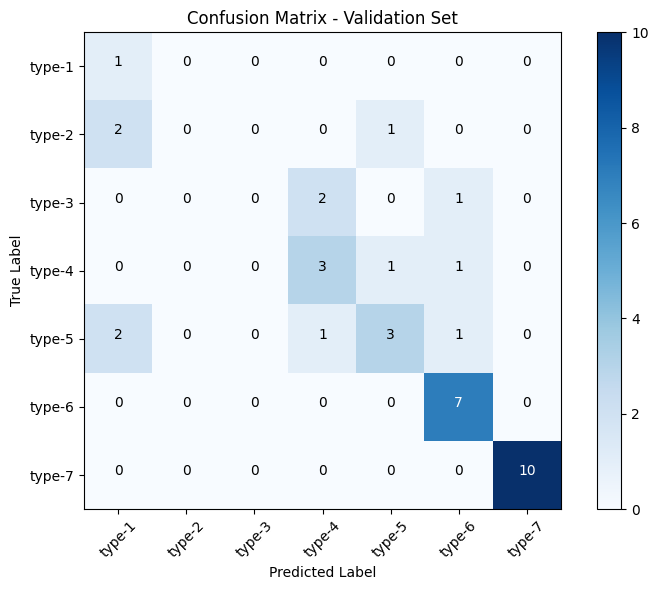

In [33]:

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


In [ ]:
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

      type-1       0.20      1.00      0.33         1
      type-2       0.00      0.00      0.00         3
      type-3       0.00      0.00      0.00         3
      type-4       0.50      0.60      0.55         5
      type-5       0.60      0.43      0.50         7
      type-6       0.70      1.00      0.82         7
      type-7       1.00      1.00      1.00        10

    accuracy                           0.67        36
   macro avg       0.43      0.58      0.46        36
weighted avg       0.61      0.67      0.62        36



/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

# ====== Save Model ======

In [ ]:
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")


# ====== Example FastAPI Deployment ======

In [ ]:
# Save this part as 'app.py' to deploy with `uvicorn app:app --reload`
fastapi_code = '''
from fastapi import FastAPI, File, UploadFile
from PIL import Image
import io
import torch
from torchvision import transforms, models
import torch.nn.functional as F

app = FastAPI()

IMG_SIZE = 224
NUM_CLASSES = 7
MODEL_PATH = "stool_resnet18.pth"

device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

class_labels = sorted(os.listdir("path_to_your_unzipped_dataset/data"))

@app.post("/predict")
async def predict(image_file: UploadFile = File(...)):
    contents = await image_file.read()
    image = Image.open(io.BytesIO(contents)).convert("RGB")
    img_t = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img_t)
        probs = F.softmax(outputs, dim=1)
        top_prob, top_cls = torch.max(probs, 1)
        predicted_label = class_labels[top_cls.item()]
        confidence = top_prob.item()
    return {"predicted_type": predicted_label, "confidence": confidence}
'''


In [ ]:

# Write FastAPI code to file
with open("app.py", "w") as f:
    f.write(fastapi_code)
print("FastAPI example code saved to 'app.py'")
